# Win probability vs models

The purpose of this notebook is to compare the predicted win probability for models with measures of how much a team won by. This will be used in the paper.

In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Predictions data

In [26]:
df = pd.read_csv('../data/Final Data/start_to_finish_with_preds_and_scores.csv')

In [27]:
df.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,xgb_pred,knn_pred,knn_no_batting_pred,nn_pred,xgb_proba,knn_proba,knn_no_batting_proba,nn_proba,home_score,away_score
0,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,0.0,0.0,1.0,0,0.452681,0.500000,0.520000,0.455505,4,1
1,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,0.0,0.0,1.0,0,0.452681,0.500000,0.520000,0.455505,6,5
2,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,0.0,0.0,1.0,0,0.452681,0.500000,0.520000,0.455505,5,1
3,-0.100639,-0.023374,-0.075552,4.0,1.214434,-0.018717,-0.010464,2.0,0.0,-0.010464,...,0.0,0.0,1.0,0,0.377228,0.473333,0.506667,0.395637,3,5
4,0.028053,0.009820,0.030927,1.0,1.179045,0.077540,-0.010464,83.0,0.0,-0.010464,...,1.0,1.0,1.0,1,0.629717,0.533333,0.546667,0.508145,4,3


## Score differential

We will model score differential by a probability distribution. The idea is to transform the score differential into a scale that makes sense. For example, is winning by 2 "twice as good" as winning by 1? Probably not. So we want to probabilistically rescale it so that score differentials are expressed in a historical context.

We'll do this by getting an answer to the following question: In what percentage of all games did the home team win by the given score differential or less? For example, in what percentage of games did the home team win by 5 or less runs?

While this is phrased in terms of home team wins, obviously the away team can win as well. So a negative score differential will indicate an away team win. Thus "what percentage of the time did the home team win by -3 or less" is equivalent to saying "what percentage of the time did the away team win by 3 or less."

The advantage of this approach is two-fold:
1. It scales the score differential between -1 and 1
2. It allows context, as discussed above.

### Raw score differential

In [28]:
df['score_diff'] = df['home_score'] - df['away_score']

<AxesSubplot:ylabel='Frequency'>

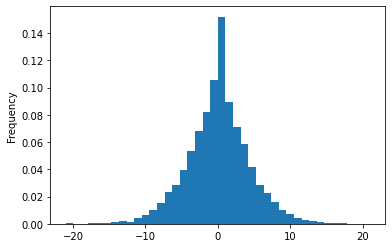

In [29]:
df['score_diff'].plot(kind='hist', density=True, bins=40)

### Scaled score differential

Split into home and away team wins.

In [30]:
home_win_df = df[df['home_win'] == 1]
away_win_df = df[df['home_win'] == 0]

In [31]:
assert home_win_df.shape[0] + away_win_df.shape[0] == df.shape[0]

<AxesSubplot:ylabel='Frequency'>

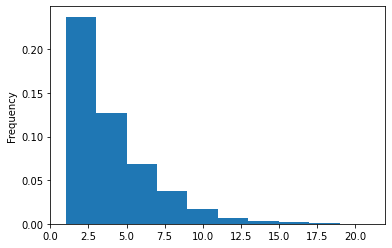

In [32]:
home_win_df['score_diff'].plot(kind='hist', density=True)

<AxesSubplot:ylabel='Frequency'>

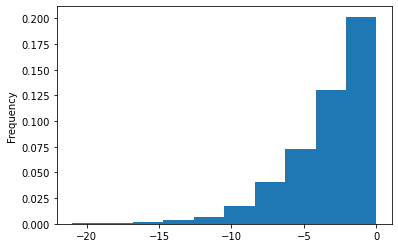

In [33]:
away_win_df['score_diff'].plot(kind='hist', density=True)

Create cumulative distributions by summing up from zero to $\pm$ largest score differential.

In [34]:
home_prob_by_diff = home_win_df['score_diff'].value_counts().sort_index() / home_win_df.shape[0]
away_prob_by_diff = away_win_df['score_diff'].value_counts().sort_index() / away_win_df.shape[0]
home_prob_by_diff

1     0.298597
2     0.175988
3     0.139734
4     0.114593
5     0.081253
6     0.055383
7     0.043906
8     0.031882
9     0.019311
10    0.014028
11    0.008563
12    0.005283
13    0.004372
14    0.002551
15    0.001457
16    0.001640
17    0.000547
18    0.000364
19    0.000182
20    0.000182
21    0.000182
Name: score_diff, dtype: float64

In [35]:
away_prob_by_diff

-21    0.000209
-20    0.000418
-19    0.000209
-18    0.000209
-17    0.000836
-16    0.000836
-15    0.001880
-14    0.002716
-13    0.004805
-12    0.003760
-11    0.010236
-10    0.015041
-9     0.022352
-8     0.033633
-7     0.052851
-6     0.064759
-5     0.088991
-4     0.119699
-3     0.153123
-2     0.185502
-1     0.237727
 0     0.000209
Name: score_diff, dtype: float64

In [36]:
home_win_cdf = np.cumsum(home_prob_by_diff)

# Since score differentials in away_prob_by_diff are negative, we need to sum it up backwards. 
# https://stackoverflow.com/questions/16541618/perform-a-reverse-cumulative-sum-on-a-numpy-array/16541726
# We also make it negative so that away team wins have negative dominance.
away_win_cdf = -np.cumsum(away_prob_by_diff[::-1])[::-1]

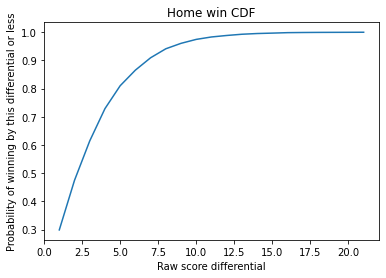

In [37]:
plt.plot(home_win_cdf.index, home_win_cdf)
plt.xlabel('Raw score differential')
plt.ylabel('Probability of winning by this differential or less')
plt.title('Home win CDF');

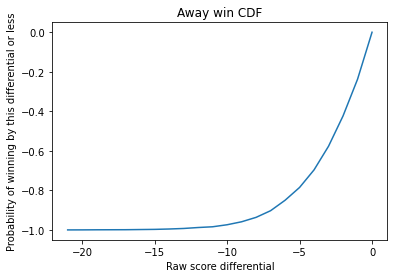

In [38]:
plt.plot(away_win_cdf.index, away_win_cdf)
plt.xlabel('Raw score differential')
plt.ylabel('Probability of winning by this differential or less')
plt.title('Away win CDF');

In [39]:
dominance_df = pd.concat([away_win_cdf, home_win_cdf])

In [40]:
dominance_df

-21   -1.000000
-20   -0.999791
-19   -0.999373
-18   -0.999164
-17   -0.998956
-16   -0.998120
-15   -0.997284
-14   -0.995404
-13   -0.992689
-12   -0.987884
-11   -0.984124
-10   -0.973888
-9    -0.958847
-8    -0.936495
-7    -0.902862
-6    -0.850010
-5    -0.785252
-4    -0.696261
-3    -0.576562
-2    -0.423438
-1    -0.237936
 0    -0.000209
 1     0.298597
 2     0.474586
 3     0.614320
 4     0.728912
 5     0.810166
 6     0.865549
 7     0.909455
 8     0.941337
 9     0.960649
 10    0.974677
 11    0.983239
 12    0.988522
 13    0.992895
 14    0.995445
 15    0.996903
 16    0.998543
 17    0.999089
 18    0.999453
 19    0.999636
 20    0.999818
 21    1.000000
Name: score_diff, dtype: float64

Looks like a sigmoid function!

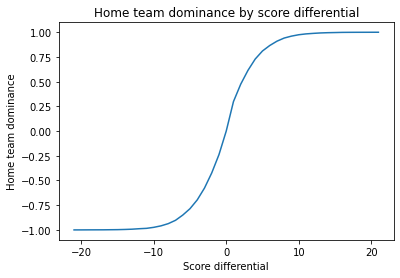

In [41]:
plt.plot(dominance_df.index, dominance_df.values)
plt.title('Home team dominance by score differential')
plt.xlabel('Score differential')
plt.ylabel('Home team dominance');

Now let's make a function which, given a score differential, returns the "dominance" score.

In [42]:
def dominance(score_diff):
    return dominance_df.loc[score_diff]

## Dominance vs predicted probability

In [43]:
df['dominance'] = df['score_diff'].map(dominance)

In [44]:
df['nn_proba_scaled'] = (df['nn_proba'] - 0.5) * 2
df['xgb_proba_scaled'] = (df['xgb_proba'] - 0.5) * 2
df['knn_proba_scaled'] = (df['knn_proba'] - 0.5) * 2

In [45]:
df['nn_proba_scaled_rounded'] = np.round(df['nn_proba_scaled'], 1)
df['xgb_proba_scaled_rounded'] = np.round(df['xgb_proba_scaled'], 1)
df['knn_proba_scaled_rounded'] = np.round(df['knn_proba_scaled'], 1)

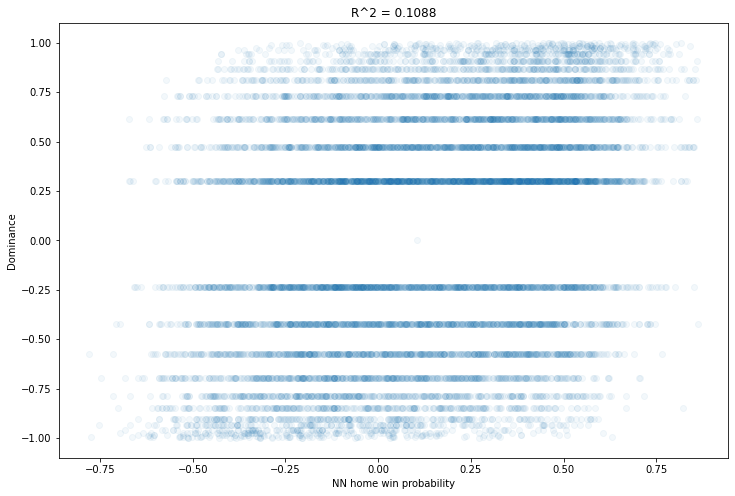

In [46]:
plt.figure(figsize=(12, 8))
plt.scatter((df['nn_proba'] - 0.5) * 2, df['dominance'], alpha=0.05)
plt.xlabel('NN home win probability')
plt.ylabel('Dominance');
plt.title(f'R^2 = {np.corrcoef(df["dominance"], df["nn_proba"])[0, 1]**2:.4f}');

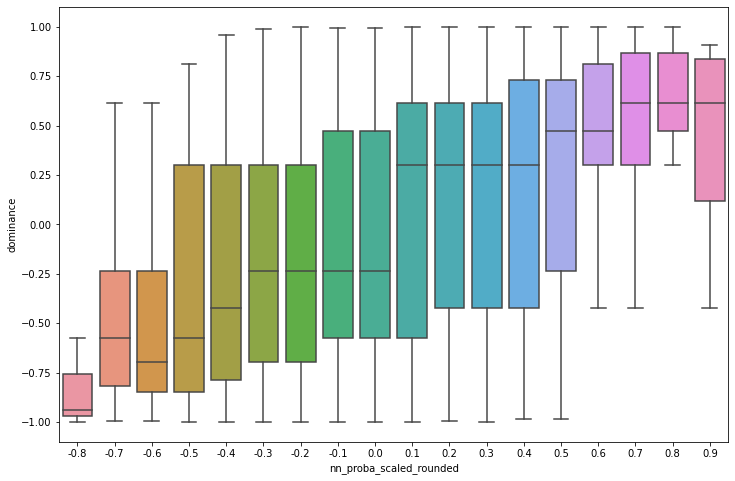

In [47]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='nn_proba_scaled_rounded', y='dominance', data=df, fliersize=0, orient='v');

<AxesSubplot:xlabel='nn_proba_scaled', ylabel='dominance'>

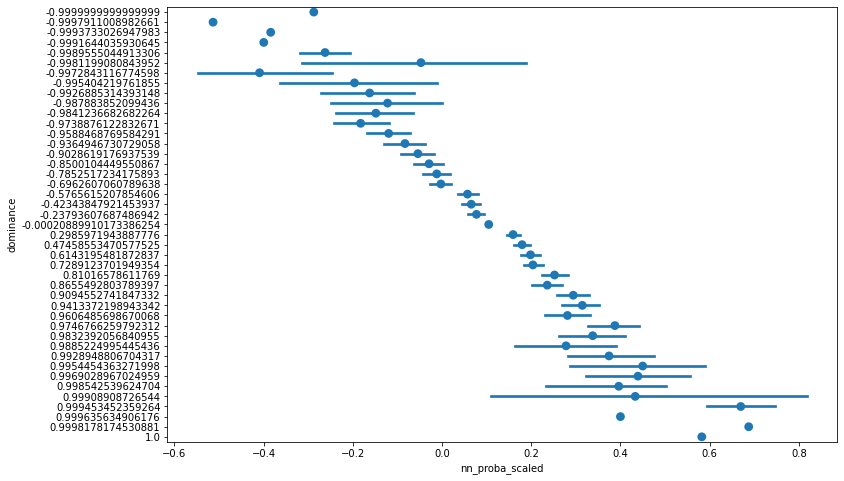

In [48]:
plt.figure(figsize=(12, 8))

sns.pointplot(x='nn_proba_scaled', y='dominance', data=df, orient='h', join=False)

<AxesSubplot:xlabel='nn_proba_scaled_rounded', ylabel='dominance'>

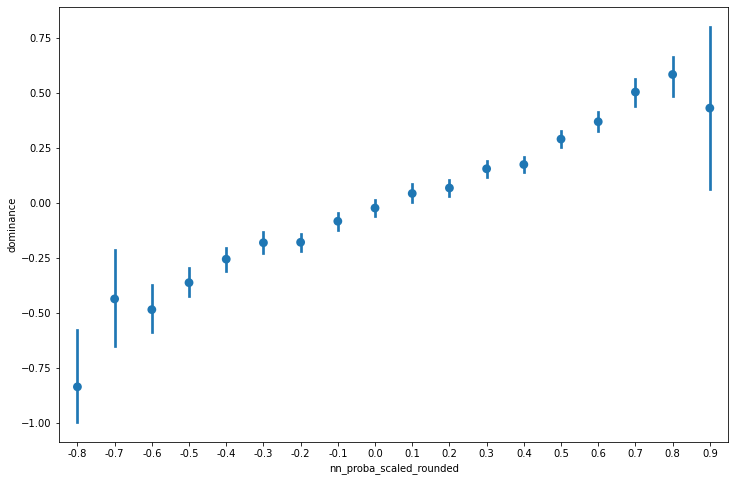

In [49]:
plt.figure(figsize=(12, 8))

sns.pointplot(x='nn_proba_scaled_rounded', y='dominance', data=df, orient='v', join=False)

<AxesSubplot:xlabel='nn_proba_scaled_rounded', ylabel='score_diff'>

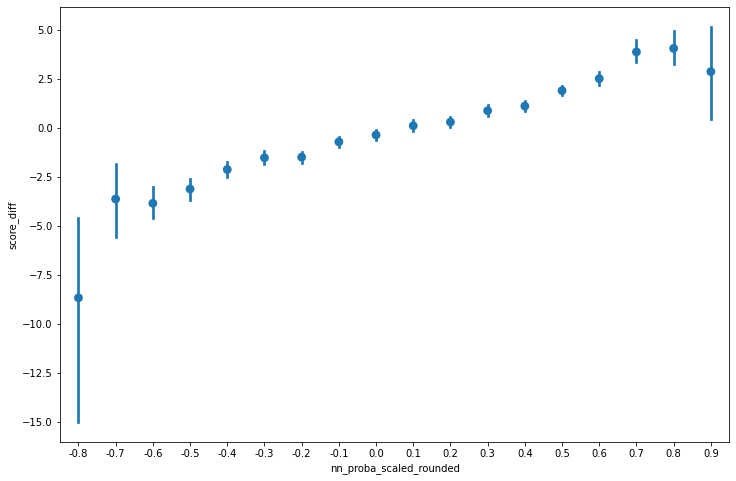

In [50]:
plt.figure(figsize=(12, 8))

sns.pointplot(x='nn_proba_scaled_rounded', y='score_diff', data=df, orient='v', join=False)

<AxesSubplot:xlabel='nn_proba_scaled', ylabel='score_diff'>

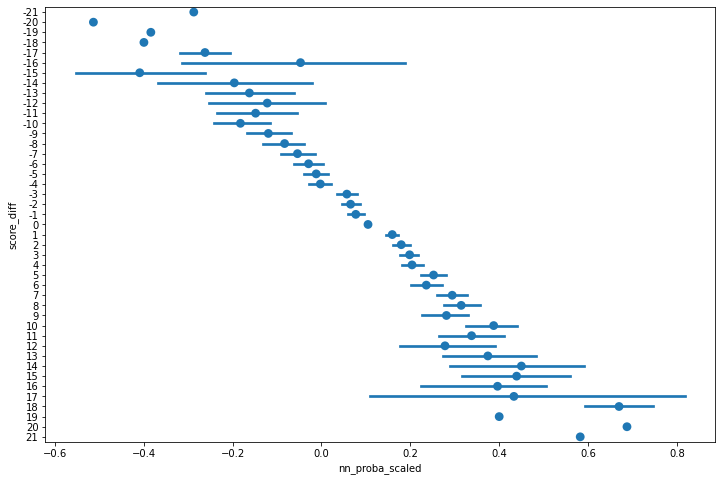

In [51]:
plt.figure(figsize=(12, 8))

sns.pointplot(x='nn_proba_scaled', y='score_diff', data=df, orient='h', join=False)

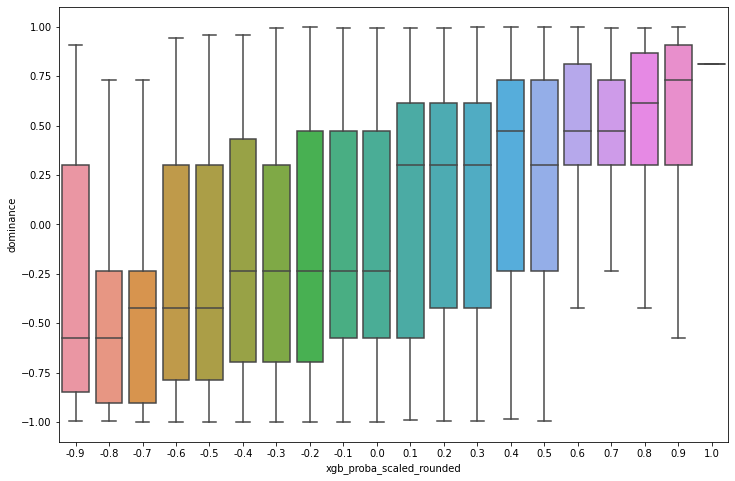

In [52]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='xgb_proba_scaled_rounded', y='dominance', data=df, fliersize=0, orient='v');

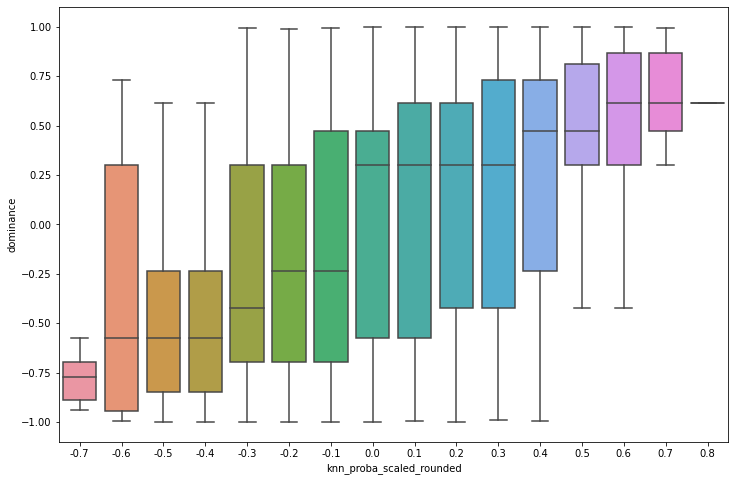

In [53]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='knn_proba_scaled_rounded', y='dominance', data=df, fliersize=0, orient='v');

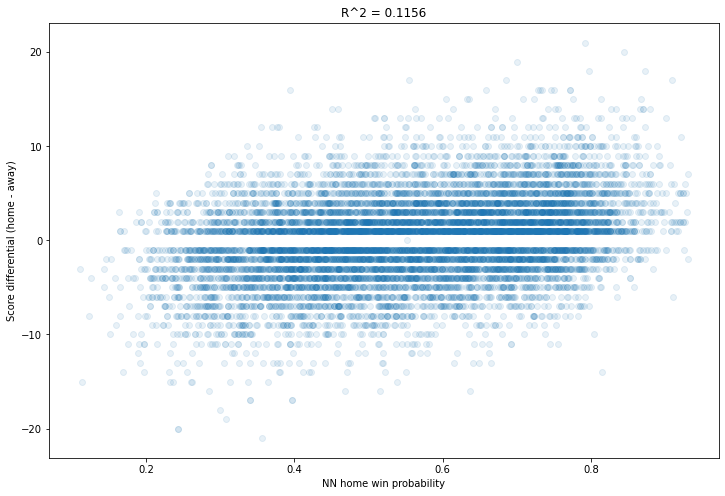

In [54]:
plt.figure(figsize=(12, 8))
plt.scatter(df['nn_proba'], df['score_diff'], alpha=0.1)
plt.xlabel('NN home win probability')
plt.ylabel('Score differential (home - away)');
plt.title(f'R^2 = {np.corrcoef(df["nn_proba"], df["score_diff"])[0, 1]**2:.4f}');

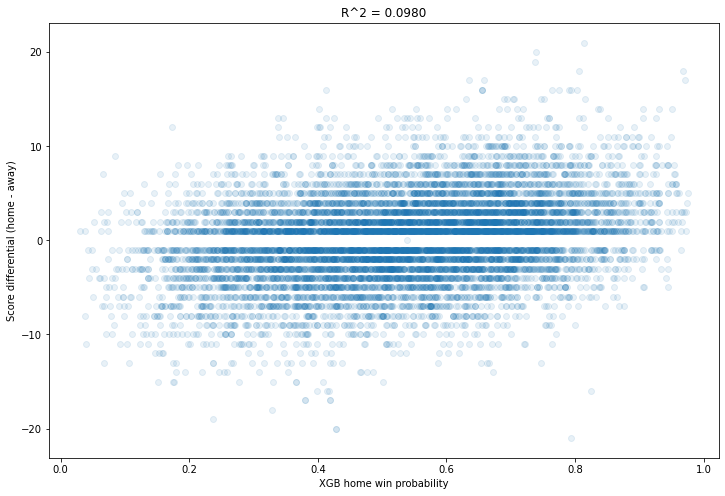

In [55]:
plt.figure(figsize=(12, 8))
plt.scatter(df['xgb_proba'], df['score_diff'], alpha=0.1)
plt.xlabel('XGB home win probability')
plt.ylabel('Score differential (home - away)');
plt.title(f'R^2 = {np.corrcoef(df["xgb_proba"], df["score_diff"])[0, 1]**2:.4f}');

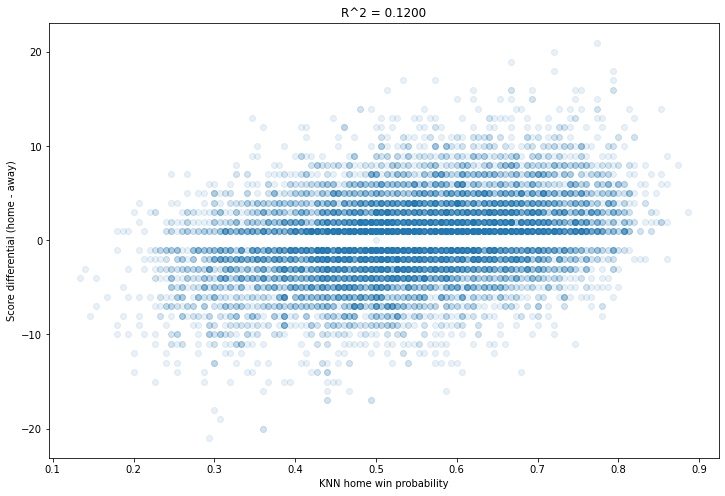

In [56]:
plt.figure(figsize=(12, 8))
plt.scatter(df['knn_proba'], df['score_diff'], alpha=0.1)
plt.xlabel('KNN home win probability')
plt.ylabel('Score differential (home - away)');
plt.title(f'R^2 = {np.corrcoef(df["knn_proba"], df["score_diff"])[0, 1]**2:.4f}');

## Statistics

Here I'll calculate some relevant statistics. These will be good for including in the abstract. In general, the statistics below focus more on the _probabilities_, rather than on simply making a correct prediction or not. We know our models don't make win/loss predictions at _quite_ state of the art, they're slightly below. But our probabilities are better, as the metrics below show.

### Brier score

[Discussed here](https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/), lower is better. The Brier scores below are in-line with or better than in the papers we read.

In [57]:
from sklearn.metrics import brier_score_loss

In [58]:
print(f'NN Brier score = {brier_score_loss(df["home_win"], df["nn_proba"]):.4f}')
print(f'XGB Brier score = {brier_score_loss(df["home_win"], df["xgb_proba"]):.4f}')
print(f'KNN Brier score = {brier_score_loss(df["home_win"], df["knn_proba"]):.4f}')

NN Brier score = 0.2292
XGB Brier score = 0.2340
KNN Brier score = 0.2274


### Area under ROC curve
[Discussed here](https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/), higher is better. These are better than in the papers we read.

In [59]:
from sklearn.metrics import roc_auc_score

In [60]:
print(f"NN AUROC = {roc_auc_score(df['home_win'], df['nn_proba']):.4f}")
print(f"XGB AUROC = {roc_auc_score(df['home_win'], df['xgb_proba']):.4f}")
print(f"KNN AUROC = {roc_auc_score(df['home_win'], df['knn_proba']):.4f}")

NN AUROC = 0.6653
XGB AUROC = 0.6518
KNN AUROC = 0.6686


## Comparison to 538

Fivethirtyeight makes their [predictions available](https://github.com/fivethirtyeight/data/tree/master/mlb-elo), which include win probabilities. Let's compare our results to theirs.

In [61]:
fte_df = pd.read_csv('../data/538_mlb_elo.csv')

Per [the documentation](https://github.com/fivethirtyeight/data/tree/master/mlb-elo), `team1` is always the home team, and `elo_prob1` is the predicted probability of the home team winning.

In [62]:
fte_df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2021-10-03,2021,0,NaN,ATL,NYM,1551.109895,1503.501067,0.601619,0.398381,...,NaN,NaN,NaN,NaN,0.575795,0.424205,NaN,NaN,NaN,NaN
1,2021-10-03,2021,0,NaN,STL,CHC,1502.349243,1468.771068,0.582111,0.417889,...,NaN,NaN,NaN,NaN,0.566486,0.433514,NaN,NaN,NaN,NaN
2,2021-10-03,2021,0,NaN,SEA,ANA,1506.798810,1481.622155,0.570302,0.429698,...,NaN,NaN,NaN,NaN,0.545822,0.454178,NaN,NaN,NaN,NaN
3,2021-10-03,2021,0,NaN,LAD,MIL,1595.777724,1547.693001,0.602275,0.397725,...,NaN,NaN,NaN,NaN,0.614708,0.385292,NaN,NaN,NaN,NaN
4,2021-10-03,2021,0,NaN,KCR,MIN,1469.856717,1482.131210,0.516868,0.483132,...,NaN,NaN,NaN,NaN,0.498403,0.501597,NaN,NaN,NaN,NaN


In [63]:
fte_df = fte_df[fte_df['season'] >= 2016]
fte_df = fte_df[fte_df['season'] <= 2019]

Based on eyeballing the data and [the website](https://projects.fivethirtyeight.com/2019-mlb-predictions/games/) _I think_ `team1` is the away team and `team2` is the home team.

In [64]:
fte_df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
3380,2019-10-30,2019,0,w,HOU,WSN,1599.542804,1584.363378,0.574617,0.425383,...,56.920649,61.723620,0.989236,27.776342,0.515172,0.484828,1587.973463,1583.382133,2.0,6.0
3381,2019-10-29,2019,0,w,HOU,WSN,1605.069000,1578.837182,0.595209,0.404791,...,62.975093,60.272516,28.723451,21.776276,0.594638,0.405362,1591.026009,1580.329587,2.0,7.0
3382,2019-10-27,2019,0,w,WSN,HOU,1584.005206,1599.900976,0.515546,0.484454,...,49.433198,66.891460,-29.811205,47.888341,0.373102,0.626898,1576.189971,1595.165625,1.0,7.0
3383,2019-10-26,2019,0,w,WSN,HOU,1589.985555,1593.920627,0.538425,0.461575,...,56.003581,51.251046,0.823752,-24.893480,0.586974,0.413026,1578.722119,1592.633477,1.0,8.0
3384,2019-10-25,2019,0,w,WSN,HOU,1593.827376,1590.078806,0.553044,0.446956,...,54.036365,57.096801,-9.053908,2.440389,0.526852,0.473148,1583.715416,1587.640180,1.0,4.0


In [65]:
fte_df['score_diff'] = fte_df['score1'] - fte_df['score2']

In [66]:
fte_df['home_win_prob_rounded'] = fte_df['elo_prob1'].apply(lambda x: np.round(x, 1))
fte_df['home_win_prob_rounded_scaled'] = (2 * (fte_df['elo_prob1'] - 0.5)).apply(lambda x: np.round(x, 1))

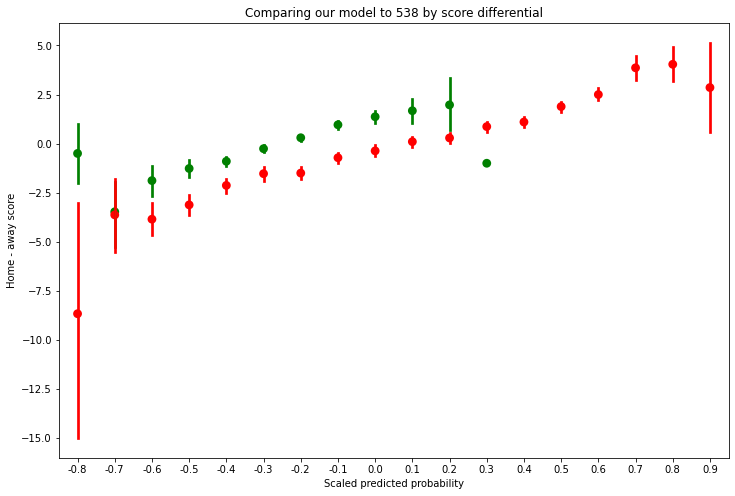

In [67]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.pointplot(x='home_win_prob_rounded_scaled', y='score_diff', data=fte_df, orient='v', join=False, label='538', color='green')
sns.pointplot(x='nn_proba_scaled_rounded', y='score_diff', data=df, orient='v', join=False, label='NN', color='red')
plt.xlabel('Scaled predicted probability')
plt.ylabel('Home - away score')
plt.title('Comparing our model to 538 by score differential');

Also comparing dominance.

In [74]:
fte_df['dominance'] = fte_df['score_diff'].apply(dominance)

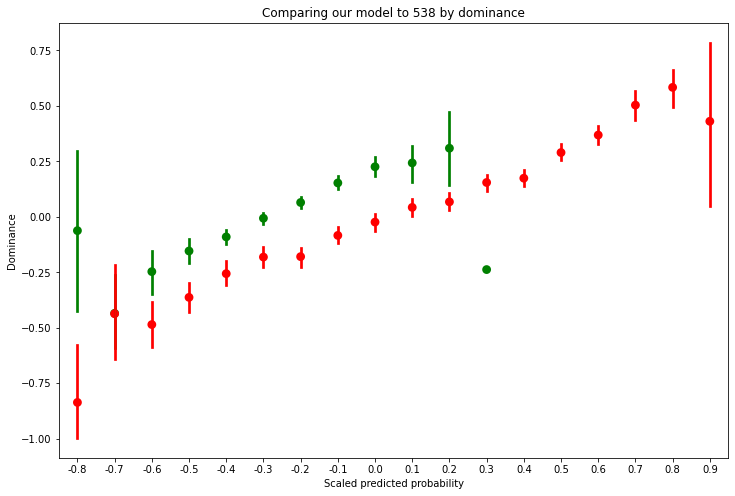

In [75]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.pointplot(x='home_win_prob_rounded_scaled', y='dominance', data=fte_df, orient='v', join=False, label='538', color='green')
sns.pointplot(x='nn_proba_scaled_rounded', y='dominance', data=df, orient='v', join=False, label='NN', color='red')
plt.xlabel('Scaled predicted probability')
plt.ylabel('Dominance')
plt.title('Comparing our model to 538 by dominance');

Repeat again, now using `rating_prob1` (

In [136]:
fte_df['home_win_rating_prob_rounded'] = fte_df['rating_prob1'].apply(lambda x: np.round(x, 1))
fte_df['home_win_rating_prob_rounded_scaled'] = (2 * (fte_df['rating_prob1'] - 0.5)).apply(lambda x: np.round(x, 1))

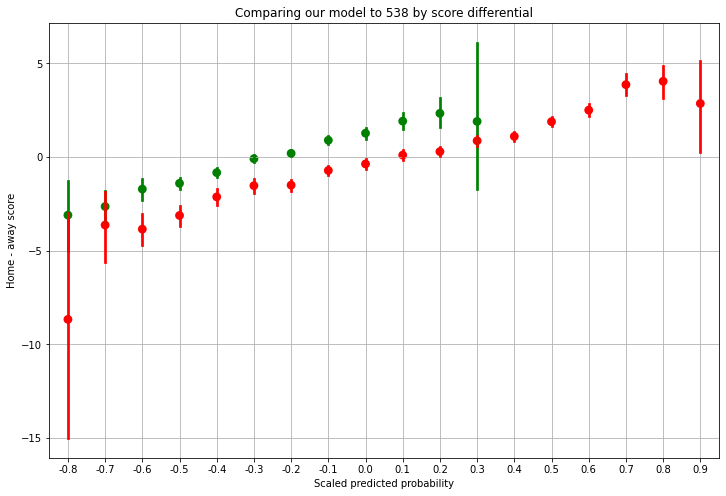

In [139]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.pointplot(x='home_win_rating_prob_rounded_scaled', y='score_diff', data=fte_df, orient='v', join=False, label='538', color='green')
sns.pointplot(x='nn_proba_scaled_rounded', y='score_diff', data=df, orient='v', join=False, label='NN', color='red')
plt.xlabel('Scaled predicted probability')
plt.ylabel('Home - away score')
plt.grid()
plt.title('Comparing our model to 538 by score differential');

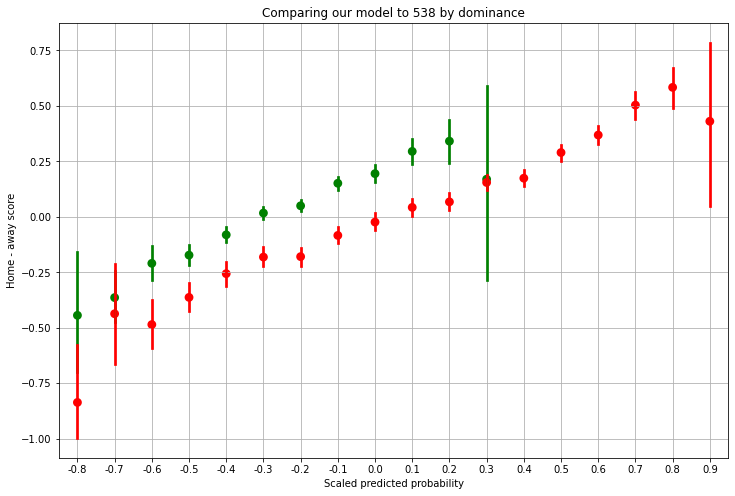

In [140]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.pointplot(x='home_win_rating_prob_rounded_scaled', y='dominance', data=fte_df, orient='v', join=False, label='538', color='green')
sns.pointplot(x='nn_proba_scaled_rounded', y='dominance', data=df, orient='v', join=False, label='NN', color='red')
plt.xlabel('Scaled predicted probability')
plt.ylabel('Home - away score')
plt.grid()
plt.title('Comparing our model to 538 by dominance');

The number of games nearly match.

In [68]:
fte_df.shape[0]

9861

In [69]:
df.shape[0]

10276

In [70]:
fte_df['season'].min(), fte_df['season'].max()

(2016, 2019)

In [71]:
df['Y'].min(), df['Y'].max()

(2016, 2019)

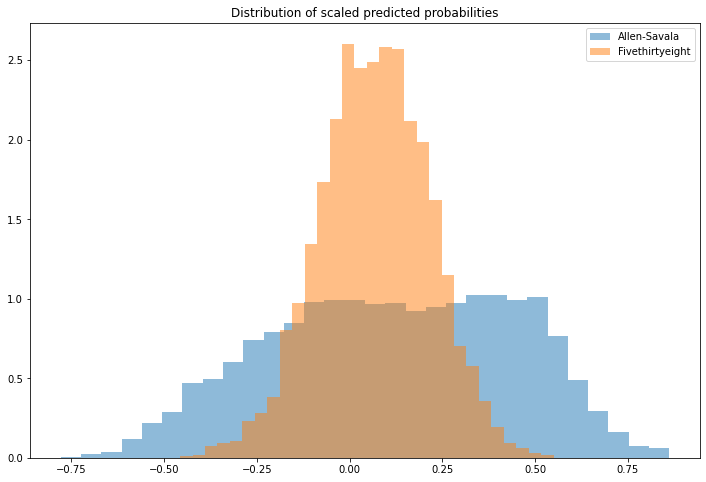

In [79]:
plt.figure(figsize=(12, 8))

plt.hist(df['nn_proba_scaled'], bins=30, label='Allen-Savala', density=True, alpha=0.5)
plt.hist(2 * (fte_df['elo_prob1'] - 0.5), bins=30, label='Fivethirtyeight', density=True, alpha=0.5)
plt.title('Distribution of scaled predicted probabilities')
plt.legend();

## Betting

Doing my best to get some kind of interesting results from betting lines.

In [248]:
bet_df = pd.read_csv('../data/mlb_betting_2019.csv')

Team names don't quite match. Run them through the uniformizer plus use Morgan's hand-labeling.

In [249]:
from utils.data_cleaning import uniform_name

bet_df['Team'] = bet_df['Team'].str.upper()

team_dict = {'SDG': 'SDN', 'SFO': 'SFN', 'TAM': 'TBA', 'CUB': 'CHN', 'KAN': 'KCA'}
bet_df['Team'] = bet_df['Team'].replace(team_dict)

bet_df['Team'] = bet_df['Team'].apply(uniform_name)

assert set(bet_df['Team'].unique()) == set(df['home_team'].unique())

In [250]:
bet_df['M'] = bet_df['Date'].astype(str).str.slice(0, 1).astype(float) # Match df
bet_df['D'] = bet_df['Date'].astype(str).str.slice(1).astype(int)
bet_df['Y'] = 2019

In [251]:
# V = visitor, H = home. I'm guessing N = None (maybe an overseas game?). There's only
# four such examples, so just drop them.
bet_df = bet_df[bet_df['VH'] != 'N'].reset_index(drop=True)

In [252]:
bet_df.head(6)

,Date,Rot,VH,Team,Pitcher,1st,2nd,3rd,4th,5th,...,Close,Run Line,Run Line Money,Open OU,Open OU Money,Close OU,Close OU Money,M,D,Y
0,328,905,V,NYN,JDEGROM-R,1,0,0,0,0,...,115,1.5,-215,6.5,-110,6.5,-105,3.0,28,2019
1,328,906,H,WAS,MSCHERZER-R,0,0,0,0,0,...,-125,-1.5,180,6.5,-110,6.5,-115,3.0,28,2019
2,328,907,V,SLN,MMIKOLAS-R,0,3,0,0,0,...,104,1.5,-205,8.5,-110,8.5,-120,3.0,28,2019
3,328,908,H,MIL,JCHACIN-R,0,1,3,0,1,...,-114,-1.5,172,8.5,-110,8.5,100,3.0,28,2019
4,328,909,V,ATL,JTEHERAN-R,0,1,0,0,0,...,170,1.5,-130,7.5,-110,8.0,-105,3.0,28,2019
5,328,910,H,PHI,ANOLA-R,1,0,0,2,0,...,-185,-1.5,110,7.5,-110,8.0,-115,3.0,28,2019


Each game is split into two successive rows. The first is the visiting team and their score and info, and the second is the home team and their score and info. In order to make this easier to work with. I'll just do this by going through the rows.

In [255]:
# This will be used to store a summary of the games. Converted to a DF later.
game_bet_data = []

# Go by 2's to get only the visitors, then manually grab the home team
for i in range(0, bet_df.shape[0], 2):
    visitor_row = bet_df.iloc[i]
    home_row = bet_df.iloc[i+1]
    assert visitor_row['Date'] == home_row['Date']
    game_dict = {
        'date': visitor_row['Date'],
        'Y': 2019,
        'M': visitor_row['M'],
        'D': visitor_row['D'],
        'away_team': visitor_row['Team'],
        'home_team': home_row['Team'],
        'away_score': visitor_row['Final'],
        'home_score': home_row['Final'],
        'score_diff': home_row['Final'] - visitor_row['Final'],
        'away_run_line': visitor_row['Run Line'],
        'away_run_line_money': visitor_row['Run Line Money'],
        'home_run_line': home_row['Run Line'],
        'home_run_line_money': home_row['Run Line Money']}
    game_bet_data.append(game_dict)
    
game_bet_df = pd.DataFrame(game_bet_data)

In [256]:
game_bet_df.head()

,date,Y,M,D,away_team,home_team,away_score,home_score,score_diff,away_run_line,away_run_line_money,home_run_line,home_run_line_money
0,328,2019,3.0,28,NYN,WAS,2,0,-2,1.5,-215,-1.5,180
1,328,2019,3.0,28,SLN,MIL,4,5,1,1.5,-205,-1.5,172
2,328,2019,3.0,28,ATL,PHI,4,10,6,1.5,-130,-1.5,110
3,328,2019,3.0,28,PIT,CIN,3,5,2,1.5,-215,-1.5,180
4,328,2019,3.0,28,ARI,LAN,5,12,7,1.5,-145,-1.5,125


In [258]:
df.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,home_score,away_score,score_diff,dominance,nn_proba_scaled,xgb_proba_scaled,knn_proba_scaled,nn_proba_scaled_rounded,xgb_proba_scaled_rounded,knn_proba_scaled_rounded
0,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,4,1,3,0.614320,-0.088991,-0.094638,0.000000,-0.1,-0.1,0.0
1,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,6,5,1,0.298597,-0.088991,-0.094638,0.000000,-0.1,-0.1,0.0
2,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,5,1,4,0.728912,-0.088991,-0.094638,0.000000,-0.1,-0.1,0.0
3,-0.100639,-0.023374,-0.075552,4.0,1.214434,-0.018717,-0.010464,2.0,0.0,-0.010464,...,3,5,-2,-0.423438,-0.208727,-0.245543,-0.053333,-0.2,-0.2,-0.1
4,0.028053,0.009820,0.030927,1.0,1.179045,0.077540,-0.010464,83.0,0.0,-0.010464,...,4,3,1,0.298597,0.016291,0.259434,0.066667,0.0,0.3,0.1


In [259]:
merged_df = pd.merge(df, 
                     game_bet_df, 
                     how='inner', 
                     on=['Y', 'M', 'home_team', 'home_score', 'away_team', 'away_score'])

In [279]:
merged_df['score_diff'] = merged_df['home_score'] - merged_df['away_score']

In [280]:
merged_df.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,date,D,score_diff_y,away_run_line,away_run_line_money,home_run_line,home_run_line_money,pred_home_cover,pred_away_cover,score_diff
0,-0.097619,-0.024730,-0.079811,3.0,1.246057,0.092010,-0.191850,-34.0,0.986926,-0.010464,...,328,28,8,-1.5,-125,1.5,105,False,True,8
1,0.017525,-0.001536,-0.005237,5.0,1.307919,0.104308,-0.010464,-150.0,0.000000,-0.010464,...,328,28,2,1.5,-190,-1.5,162,False,True,2
2,0.017525,-0.001536,-0.005237,5.0,1.307919,0.104308,0.332158,-150.0,0.994740,-0.003513,...,328,28,2,1.5,-190,-1.5,162,False,False,2
3,0.017525,-0.001536,-0.005237,5.0,1.307919,0.104308,-0.010464,-150.0,0.000000,-0.010464,...,329,29,3,1.5,-150,-1.5,130,False,True,3
4,0.017525,-0.001536,-0.005237,5.0,1.307919,0.104308,0.332158,-150.0,0.994740,-0.003513,...,329,29,3,1.5,-150,-1.5,130,False,False,3


Game counts are close, but don't _quite_ match up. Leaving it as-is for now.

In [264]:
merged_df.shape[0], game_bet_df.shape[0], df[df['Y'] == 2019].shape[0]

(2654, 2462, 2599)

In [229]:
df_away_merged.isna().sum().sum()

0

Now find a predicted probability cutoff to ensure a win/loss of at least 2 points to cover the line. Just eyeballing it for now. We could definitely do this more precisely.

The idea is that we want a probability cutoff where we can feel reasonably confident that, if the predicted win probability is greater than that, we can feel confident that they will cover the run spread. Similarly, a low probability means the home team is likely to _lose_, so we want a low enough cutoff to feel confident that the _away team_ will win by enough to cover the run line.

To do that, I'll plot the (cumulative) predicted probabilities for all games where the home team won by enough to cover the line, and also cumulative probabilities for all games where the home team lost/didn't win by enough to cover the line. Then we'll try to pick a cutoff that is as good as possible (gets predictions correct, and minimizes false positives). We'll then repeat this for away team wins.

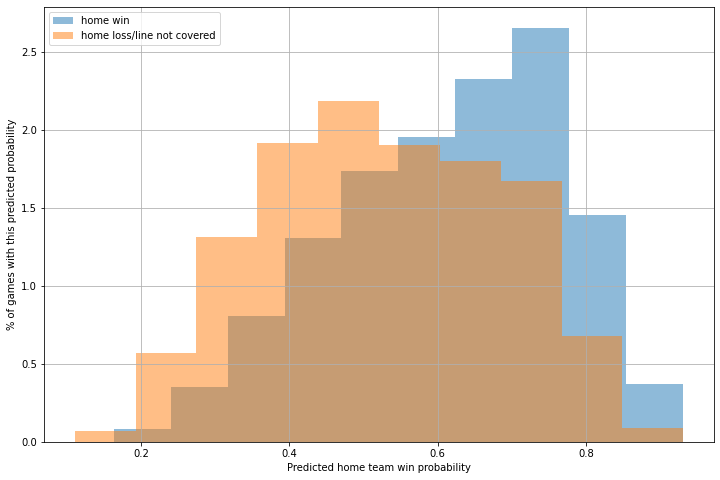

In [269]:
plt.figure(figsize=(12, 8))
df[df['score_diff'] > 1.5]['nn_proba'].hist(density=True, alpha=0.5, label='home win')
df[df['score_diff'] < 1.5]['nn_proba'].hist(density=True, alpha=0.5, label='home loss/line not covered')
plt.xlabel('Predicted home team win probability')
plt.ylabel('% of games with this predicted probability')
plt.legend();

We'll eyeball a cutoff of 0.6, which will catch a lot of the wins, and not too many of the loses/non-covered wins. This could be better done by optimizing the cutoff and looking at more years, but for right now that's good enough. One other simple idea is to not use a cutoff of 1.5 runs, since we accept that our model isn't perfect. By instead saying "I'll only bet on games where I expect the score differential to be at least (say) 5" will give a larger margin of error. For reference, here is what that histogram would look like.

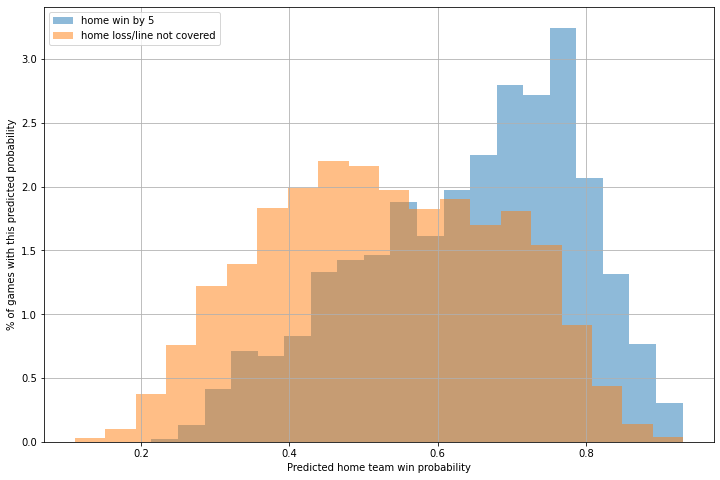

In [317]:
plt.figure(figsize=(12, 8))
df[df['score_diff'] >= 5]['nn_proba'].hist(density=True, bins=20, alpha=0.5, label='home win by 5')
df[df['score_diff'] < 1.5]['nn_proba'].hist(density=True, bins=20, alpha=0.5, label='home loss/line not covered')
plt.xlabel('Predicted home team win probability')
plt.ylabel('% of games with this predicted probability')
plt.legend();

In [231]:
win_cutoff = 0.6

Now for away teams.

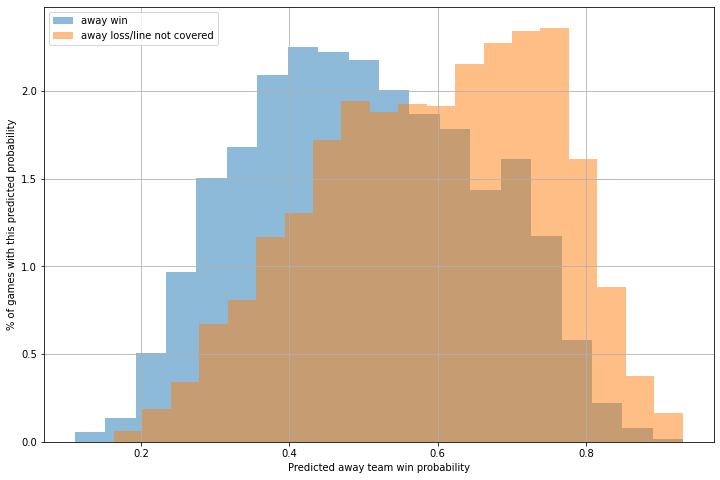

In [318]:
plt.figure(figsize=(12, 8))
df[df['score_diff'] < -1.5]['nn_proba'].hist(density=True, bins=20, alpha=0.5, label='away win')
df[df['score_diff'] > -1.5]['nn_proba'].hist(density=True, bins=20, alpha=0.5, label='away loss/line not covered')
plt.xlabel('Predicted away team win probability')
plt.ylabel('% of games with this predicted probability')
plt.legend();

Again, a reasonable balance is struck around 0.4. Let's also move to a score differential of at least -5 to separate these two slightly more.

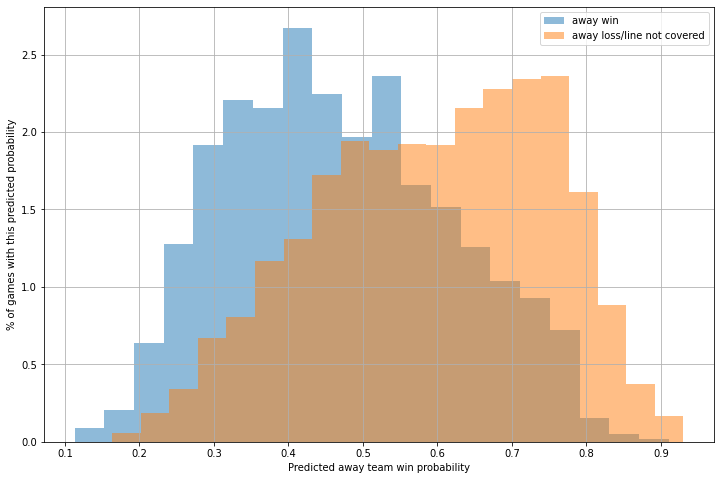

In [319]:
plt.figure(figsize=(12, 8))
df[df['score_diff'] <= -5]['nn_proba'].hist(density=True, bins=20, alpha=0.5, label='away win')
df[df['score_diff'] > -1.5]['nn_proba'].hist(density=True, bins=20, alpha=0.5, label='away loss/line not covered')
plt.xlabel('Predicted away team win probability')
plt.ylabel('% of games with this predicted probability')
plt.legend();

In [274]:
loss_cutoff = 0.5

Nowlet's make predictions. We'll use our cutoffs to predict whether or not the line will be covered. Note that our cutoffs have a "gap" between 0.5 and 0.6. So if the predicted win probability is between 0.5 and 0.6 we won't predict anything. In other words, we won't bet on that game because we're not confident enough in our answers. That strategy could really be refined, and I'm guessing could result in much larger winnings, and much lower drawdown (in investing-speak), meaning lower difference between returns on a game-to-game basis.

In [276]:
merged_df['pred_home_cover'] = merged_df['nn_proba'] > win_cutoff
merged_df['pred_away_cover'] = merged_df['nn_proba'] < loss_cutoff

We'll also record whether the run line was _actually_ covered or not.

Recall that the way this works is that the favorite has a run line of -1.5, meaning they need to win by at least 2 runs to cover the line. The underdog has a run line of +1.5, meaning they have to either win the game or lose by one run or less. For our purposes, the way to evaluate this is to take the score differential (home - away) and comparing it to the run line. I record the run line separately for the home and away teams, so there's no worry about knowing who's the underdog/favorite.

So for example, if the home team has a run line of -1.5 then they need to win by 2 runs or more, so we need `score_diff > 1.5`. If the away team has the same run line (for a different game), they need `-score_diff > 1.5` (negative, because them winning would require a negative score differential). Similarly, a run line of +1.5 for the home team means `score_diff > -1.5`, indicating a win (`score_diff > 0`) or a loss by less than 2 runs (`score_diff > -1.5`). A run line of +1.5 for the away team means `-score_diff > -1.5`, or equivalently (`score_diff < 1.5`), indicating a win (`-score_diff > 0`) or a loss by less than 2 (`score_diff > -1.5`, or equivalently `-score_diff < 1.5`).

To summarize:
- For home team, covering the line means `score_diff > -run_line`
- For away team, covering the line means `score_diff < run_line`

In [282]:
merged_df['home_cover'] = merged_df['score_diff'] > -merged_df['home_run_line']
merged_df['away_cover'] = merged_df['score_diff'] < merged_df['away_run_line']

In [283]:
merged_df.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,score_diff_y,away_run_line,away_run_line_money,home_run_line,home_run_line_money,pred_home_cover,pred_away_cover,score_diff,home_cover,away_cover
0,-0.097619,-0.024730,-0.079811,3.0,1.246057,0.092010,-0.191850,-34.0,0.986926,-0.010464,...,8,-1.5,-125,1.5,105,False,True,8,True,False
1,0.017525,-0.001536,-0.005237,5.0,1.307919,0.104308,-0.010464,-150.0,0.000000,-0.010464,...,2,1.5,-190,-1.5,162,False,True,2,True,False
2,0.017525,-0.001536,-0.005237,5.0,1.307919,0.104308,0.332158,-150.0,0.994740,-0.003513,...,2,1.5,-190,-1.5,162,False,False,2,True,False
3,0.017525,-0.001536,-0.005237,5.0,1.307919,0.104308,-0.010464,-150.0,0.000000,-0.010464,...,3,1.5,-150,-1.5,130,False,True,3,True,False
4,0.017525,-0.001536,-0.005237,5.0,1.307919,0.104308,0.332158,-150.0,0.994740,-0.003513,...,3,1.5,-150,-1.5,130,False,False,3,True,False


In [290]:
from sklearn.metrics import classification_report

print('======= Home team =======\n')
print(classification_report(merged_df['home_cover'], merged_df['pred_home_cover']))

print('\n\n======= Away team =======\n')
print(classification_report(merged_df['away_cover'], merged_df['pred_away_cover']))

======= Home team =======

              precision    recall  f1-score   support

       False       0.60      0.63      0.62      1412
        True       0.56      0.53      0.54      1242

    accuracy                           0.58      2654
   macro avg       0.58      0.58      0.58      2654
weighted avg       0.58      0.58      0.58      2654



======= Away team =======

              precision    recall  f1-score   support

       False       0.53      0.71      0.61      1242
        True       0.64      0.46      0.53      1412

    accuracy                           0.58      2654
   macro avg       0.59      0.58      0.57      2654
weighted avg       0.59      0.58      0.57      2654



How many games did we make a prediction on?

In [293]:
print(f"Home teams predicted to cover: {100*merged_df['pred_home_cover'].sum() / merged_df.shape[0]:.2f}%")
print(f"Away teams predicted to cover: {100*merged_df['pred_away_cover'].sum() / merged_df.shape[0]:.2f}%")

Home teams predicted to cover: 44.35%
Away teams predicted to cover: 38.09%


So about 82% of games we made a prediction on.

Next we incorporate money to find out returns. Per [this description](https://www.playia.com/sports-betting/mlb/run-line/) the money works as follows:
- For favorites (negative run-line) you must wager run line money to win \$100
- For underdogs (positive run-line) you must wager \$100 to win the run line money

So for each game where we make a prediction we'll wager the appropriate amount (\$100 for underdog, run line money for favorite). We'll then track our returns. 

Iterating over rows is bad, but I'm lazy and this is simpler.

In [310]:
# Use these to track amount wagered and returned
merged_df['home_wager'] = 0
merged_df['away_wager'] = 0
merged_df['home_return'] = 0
merged_df['away_return'] = 0

for i in range(merged_df.shape[0]):
    game_row = merged_df.iloc[i]
    # Home team
    # Check if we predicted anything
    if game_row['pred_home_cover']:
        # Favorite (negative) or underdog (positive)?
        if game_row['home_run_line'] < 0:
            merged_df.loc[i, 'home_wager'] = np.abs(game_row['home_run_line_money'])
            # Return of $0 or $100 depending on whether our prediction was correct or not.
            # If you win, don't forget to return the money you bet as well.
            merged_df.loc[i, 'home_return'] = int(game_row['pred_home_cover'] == game_row['home_cover']) * (np.abs(game_row['home_run_line_money']) + 100)
        else:
            merged_df.loc[i, 'home_wager'] = 100
            merged_df.loc[i, 'home_return'] = int(game_row['pred_home_cover'] == game_row['home_cover']) * (100 + game_row['home_run_line_money'])
            
    # Away team
    # Check if we predicted anything
    if game_row['pred_away_cover']:
        # Favorite (negative) or underdog (positive)?
        if game_row['away_run_line'] < 0:
            merged_df.loc[i, 'away_wager'] = np.abs(game_row['away_run_line_money'])
            # Return of $0 or $100 depending on whether our prediction was correct or not
            merged_df.loc[i, 'away_return'] = int(game_row['pred_away_cover'] == game_row['away_cover']) * (np.abs(game_row['away_run_line_money']) + 100)
        else:
            merged_df.loc[i, 'away_wager'] = 100
            merged_df.loc[i, 'away_return'] = int(game_row['pred_away_cover'] == game_row['away_cover']) * (100 + game_row['away_run_line_money'])

In [307]:
merged_df.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,home_run_line_money,pred_home_cover,pred_away_cover,score_diff,home_cover,away_cover,home_wager,away_wager,home_return,away_return
0,-0.097619,-0.024730,-0.079811,3.0,1.246057,0.092010,-0.191850,-34.0,0.986926,-0.010464,...,105,False,True,8,True,False,0,125,0,0
1,0.017525,-0.001536,-0.005237,5.0,1.307919,0.104308,-0.010464,-150.0,0.000000,-0.010464,...,162,False,True,2,True,False,0,100,0,0
2,0.017525,-0.001536,-0.005237,5.0,1.307919,0.104308,0.332158,-150.0,0.994740,-0.003513,...,162,False,False,2,True,False,0,0,0,0
3,0.017525,-0.001536,-0.005237,5.0,1.307919,0.104308,-0.010464,-150.0,0.000000,-0.010464,...,130,False,True,3,True,False,0,100,0,0
4,0.017525,-0.001536,-0.005237,5.0,1.307919,0.104308,0.332158,-150.0,0.994740,-0.003513,...,130,False,False,3,True,False,0,0,0,0


In [316]:
wagered = merged_df['home_wager'].sum() + merged_df['away_wager'].sum()
returns = merged_df['home_return'].sum() + merged_df['away_return'].sum()

print(f"Wagered: ${wagered:,}")
print(f"Returns: ${returns:,}")
print(f"Win/Losses of ${returns - wagered:,}")

Wagered: $271,159
Returns: $172,816
Win/Losses of $-98,343


Not good! Let's move all this into a function though to allow for easier tweaking of the cutoffs to see how that changes things.

In [331]:
def make_wagers(df, win_cutoff, loss_cutoff):
    df['pred_home_cover'] = df['nn_proba'] > win_cutoff
    df['pred_away_cover'] = df['nn_proba'] < loss_cutoff
    
    df['home_cover'] = df['score_diff'] > -df['home_run_line']
    df['away_cover'] = df['score_diff'] < df['away_run_line']
    
    print(f"Home teams predicted to cover: {100*df['pred_home_cover'].sum() / df.shape[0]:.2f}%")
    print(f"Away teams predicted to cover: {100*df['pred_away_cover'].sum() / df.shape[0]:.2f}%")
    
    # Use these to track amount wagered and returned
    df['home_wager'] = 0
    df['away_wager'] = 0
    df['home_return'] = 0
    df['away_return'] = 0

    for i in range(df.shape[0]):
        game_row = df.iloc[i]
        # Home team
        # Check if we predicted anything
        if game_row['pred_home_cover']:
            # Favorite (negative) or underdog (positive)?
            if game_row['home_run_line'] < 0:
                df.loc[i, 'home_wager'] = np.abs(game_row['home_run_line_money'])
                # Return of $0 or $100 depending on whether our prediction was correct or not.
                # If you win, don't forget to return the money you bet as well.
                df.loc[i, 'home_return'] = int(game_row['pred_home_cover'] == game_row['home_cover']) * (np.abs(game_row['home_run_line_money']) + 100)
            else:
                df.loc[i, 'home_wager'] = 100
                df.loc[i, 'home_return'] = int(game_row['pred_home_cover'] == game_row['home_cover']) * (100 + game_row['home_run_line_money'])

        # Away team
        # Check if we predicted anything
        if game_row['pred_away_cover']:
            # Favorite (negative) or underdog (positive)?
            if game_row['away_run_line'] < 0:
                df.loc[i, 'away_wager'] = np.abs(game_row['away_run_line_money'])
                # Return of $0 or $100 depending on whether our prediction was correct or not
                df.loc[i, 'away_return'] = int(game_row['pred_away_cover'] == game_row['away_cover']) * (np.abs(game_row['away_run_line_money']) + 100)
            else:
                df.loc[i, 'away_wager'] = 100
                df.loc[i, 'away_return'] = int(game_row['pred_away_cover'] == game_row['away_cover']) * (100 + game_row['away_run_line_money'])
                
    wagered = df['home_wager'].sum() + df['away_wager'].sum()
    returns = df['home_return'].sum() + df['away_return'].sum()

    print()
    print(f"Wagered: ${wagered:,}")
    print(f"Returns: ${returns:,}")
    print(f"Win/Losses of ${returns - wagered:,} ({100*(returns - wagered) / wagered:.2f}%)")

In [332]:
# Use same cutoffs as above for a sanity check
make_wagers(merged_df, win_cutoff=0.6, loss_cutoff=0.5)

Home teams predicted to cover: 44.35%
Away teams predicted to cover: 38.09%

Wagered: $271,159
Returns: $172,816
Win/Losses of $-98,343 (-36.27%)


In [333]:
make_wagers(merged_df, win_cutoff=0.6, loss_cutoff=0.4)

Home teams predicted to cover: 44.35%
Away teams predicted to cover: 19.25%

Wagered: $212,556
Returns: $148,223
Win/Losses of $-64,333 (-30.27%)


In [334]:
make_wagers(merged_df, win_cutoff=0.7, loss_cutoff=0.4)

Home teams predicted to cover: 24.49%
Away teams predicted to cover: 19.25%

Wagered: $144,776
Returns: $109,852
Win/Losses of $-34,924 (-24.12%)


In [335]:
make_wagers(merged_df, win_cutoff=0.7, loss_cutoff=0.3)

Home teams predicted to cover: 24.49%
Away teams predicted to cover: 6.29%

Wagered: $104,588
Returns: $90,757
Win/Losses of $-13,831 (-13.22%)


In [336]:
make_wagers(merged_df, win_cutoff=0.8, loss_cutoff=0.3)

Home teams predicted to cover: 6.82%
Away teams predicted to cover: 6.29%

Wagered: $44,019
Returns: $39,636
Win/Losses of $-4,383 (-9.96%)
